<a href="https://colab.research.google.com/github/nasarar/Post_Covid19_Vacation_Projection/blob/Ryan/covid_19_arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

In [ ]:
import datetime
from dateutil.parser import parse
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
df= pd.read_csv(
    'https://covid.ourworldindata.org/data/owid-covid-data.csv')
df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,0.026,0.026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
3,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
4,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,0.026,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,38928341.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511


In [ ]:
country_list = df.location.value_counts().keys()
country_list

Index(['Argentina', 'Mexico', 'Thailand', 'Peru', 'Taiwan', 'South Korea',
       'Japan', 'North America', 'Asia', 'World',
       ...
       'Falkland Islands', 'Aruba', 'Wallis and Futuna', 'Curacao', 'Nauru',
       'Tonga', 'Sint Maarten (Dutch part)', 'Turkmenistan', 'Tuvalu',
       'Bonaire Sint Eustatius and Saba'],
      dtype='object', length=226)

In [ ]:
#Pivot and melt method and set relative date from day-1 of tracking (December 19th, 2020)

df= pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')
df['date'] = pd.to_datetime(df['date']).dt.date
df = df.sort_values(['iso_code','date']).reset_index(drop=True)
#calculate relative date (even non -sequential)
days_delta = (df['date'] - df.groupby('iso_code')['date'].shift(1)).dt.days.fillna(1)
df['relative_date'] = 1 + days_delta
df['relative_date'] = df.groupby('iso_code')['relative_date'].cumsum() - 1


#create the same number of relative dates for each country (matching max available)
left = pd.melt(df[['iso_code','relative_date','people_vaccinated']]\
            .pivot(index='iso_code',columns='relative_date',values='people_vaccinated').reset_index(),
            id_vars=['iso_code']).sort_values(['iso_code','relative_date']).reset_index(drop=True)
df = left.drop('value',axis=1).merge(df, on=['iso_code','relative_date'], how='left')
df.tail()

#Arima Model

In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 33.0MB/s 
     |████████████████████████████████| 9.5MB 34.5MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

In [ ]:
  country = "ISL"
  df = df.sort_values('location')
  df['eid'] = (df.groupby(['location']).cumcount()==0).astype(int)
  df['eid'] = df['eid'].cumsum()
  ndf=df[df.iso_code==country]
  #check dataframe of GBR
  sndf = ndf.sort_values('people_fully_vaccinated')
  val = sndf['people_fully_vaccinated'].values * 100 /list(ndf.population)[0]

In [ ]:
ndf

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,new_vaccinations_smoothed_per_million,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,eid
37203,ISL,Europe,Iceland,2020-03-19,330.0,80.0,32.429,NaN,NaN,0.0,967.033,234.432,95.029,NaN,NaN,0.0,1.71,NaN,NaN,6.0,17.582,NaN,NaN,NaN,NaN,1311.0,9148.0,26.807,3.842,1143.0,3.349,NaN,NaN,tests performed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.93,341250.0,3.404,37.3,14.431,9.207,46482.958,0.2,117.992,5.31,14.3,15.2,NaN,2.91,82.99,0.949,93
37188,ISL,Europe,Iceland,2020-03-04,26.0,15.0,3.714,NaN,NaN,0.0,76.190,43.956,10.884,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.000,NaN,NaN,NaN,NaN,81.0,264.0,0.774,0.237,NaN,NaN,NaN,NaN,tests performed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.67,341250.0,3.404,37.3,14.431,9.207,46482.958,0.2,117.992,5.31,14.3,15.2,NaN,2.91,82.99,0.949,93
37187,ISL,Europe,Iceland,2020-03-03,11.0,5.0,NaN,NaN,NaN,NaN,32.234,14.652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000,NaN,NaN,NaN,NaN,45.0,183.0,0.536,0.132,NaN,NaN,NaN,NaN,tests performed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.67,341250.0,3.404,37.3,14.431,9.207,46482.958,0.2,117.992,5.31,14.3,15.2,NaN,2.91,82.99,0.949,93
37186,ISL,Europe,Iceland,2020-03-02,6.0,3.0,NaN,NaN,NaN,NaN,17.582,8.791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000,NaN,NaN,NaN,NaN,48.0,138.0,0.404,0.141,NaN,NaN,NaN,NaN,tests performed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.67,341250.0,3.404,37.3,14.431,9.207,46482.958,0.2,117.992,5.31,14.3,15.2,NaN,2.91,82.99,0.949,93
37192,ISL,Europe,Iceland,2020-03-08,50.0,0.0,6.714,NaN,NaN,0.0,146.520,0.000,19.676,NaN,NaN,0.0,NaN,NaN,NaN,1.0,2.930,NaN,NaN,NaN,NaN,37.0,478.0,1.401,0.108,55.0,0.161,NaN,NaN,tests performed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.67,341250.0,3.404,37.3,14.431,9.207,46482.958,0.2,117.992,5.31,14.3,15.2,NaN,2.91,82.99,0.949,93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37623,ISL,Europe,Iceland,2021-05-13,6526.0,0.0,3.714,29.0,0.0,0.0,19123.810,0.000,10.884,84.982,0.0,0.0,0.75,NaN,NaN,4.0,11.722,NaN,NaN,NaN,NaN,913.0,365254.0,1070.341,2.675,1160.0,3.399,NaN,NaN,tests performed,NaN,NaN,NaN,NaN,4844.0,NaN,NaN,NaN,14195.0,37.96,341250.0,3.404,37.3,14.431,9.207,46482.958,0.2,117.992,5.31,14.3,15.2,NaN,2.91,82.99,0.949,93
37630,ISL,Europe,Iceland,2021-05-20,6555.0,4.0,4.143,29.0,0.0,0.0,19208.791,11.722,12.140,84.982,0.0,0.0,0.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,225051.0,159327.0,76259.0,5030.0,3425.0,65.95,46.69,22.35,10037.0,NaN,341250.0,3.404,37.3,14.431,9.207,46482.958,0.2,117.992,5.31,14.3,15.2,NaN,2.91,82.99,0.949,93
37631,ISL,Europe,Iceland,2021-05-21,6555.0,0.0,2.571,29.0,0.0,0.0,19208.791,0.000,7.535,84.982,0.0,0.0,0.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,231109.0,163815.0,80464.0,6058.0,3911.0,67.72,48.00,23.58,11461.0,NaN,341250.0,3.40

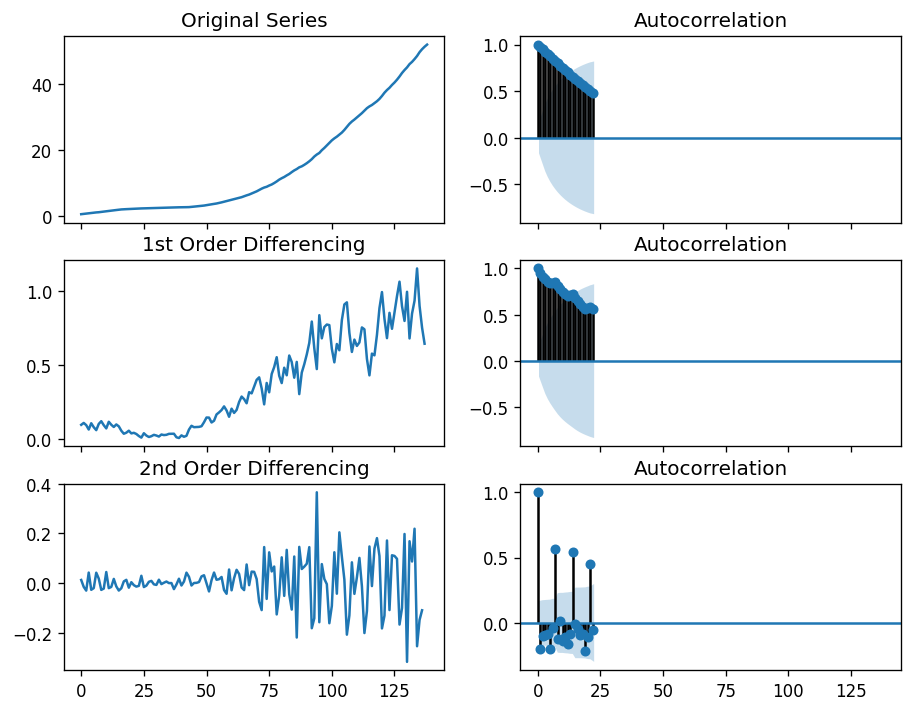

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-263.476, Time=0.25 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-243.797, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-247.191, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-250.601, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-245.566, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-262.707, Time=0.27 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-262.217, Time=0.42 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-262.163, Time=0.13 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-248.257, Time=0.14 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-259.686, Time=0.27 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-260.691, Time=0.11 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0] intercept
Total fit time: 1.853 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  

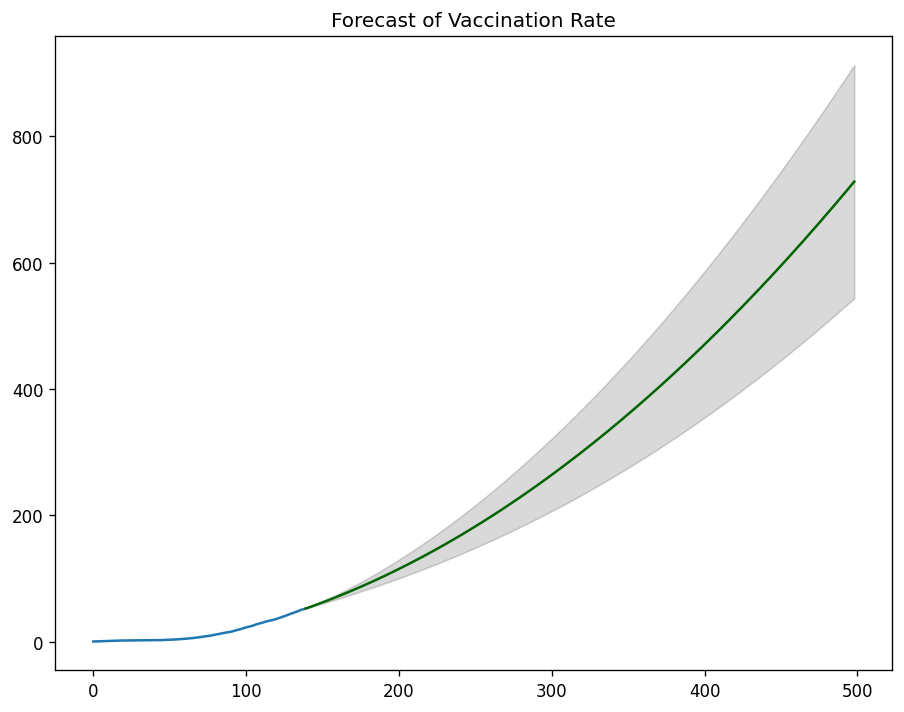

In [ ]:

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
country_list = ['CAN']
for country in country_list:
  df = df.sort_values('location')
  df['eid'] = (df.groupby(['location']).cumcount()==0).astype(int)
  df['eid'] = df['eid'].cumsum()
  ndf=df[df.iso_code==country]
  #check dataframe of GBR
  sndf = ndf.sort_values('people_vaccinated')
  val = sndf['people_vaccinated'].values * 100 /list(ndf.population)[0]

  for i in range(len(val)):
    if val[i]>=0:
      pass
    else :
      end = i
      break
  val = val[:end]
  d = list(sndf.date)[:end]
  fig, axes = plt.subplots(3, 2, sharex=True)
  axes[0, 0].plot(val); axes[0, 0].set_title('Original Series')
  plot_acf(val, ax=axes[0, 1])

  # 1st Differencing
  axes[1, 0].plot(np.diff(val)); axes[1, 0].set_title('1st Order Differencing')
  plot_acf(np.diff(val), ax=axes[1, 1])
  diffval = np.diff(val)

  # 2nd Differencing
  axes[2, 0].plot(np.diff(diffval)); axes[2, 0].set_title('2nd Order Differencing')
  plot_acf(np.diff(diffval), ax=axes[2, 1])
  plt.show()

  model = pm.auto_arima(val, start_p=1, start_q=1,
  test='adf', # use adftest to find optimal 'd'
  max_p=4, max_q=4, # maximum p and q
  m=1, # frequency of series
  d=None, # let model determine 'd'
  seasonal=False, # No Seasonality
  start_P=0,
  D=0,
  trace=True,
  error_action='ignore',
  suppress_warnings=True,
  stepwise=True)
  print(model.summary())
  # model.plot_diagnostics(figsize=(7,5))
  plt.show()
  n_periods = 12*30
  fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
  index_of_fc = np.arange(len(val), len(val)+n_periods)

  # make series for plotting purpose
  fc_series = pd.Series(fc, index=index_of_fc)
  lower_series = pd.Series(confint[:, 0], index=index_of_fc)
  upper_series = pd.Series(confint[:, 1], index=index_of_fc)
  # Plot
  plt.plot(val)
  plt.plot(fc_series, color='darkgreen')
  plt.fill_between(lower_series.index,
  lower_series,
  upper_series,
  color='k', alpha=.15)
  plt.title("Forecast of Vaccination Rate")
  plt.show()
  for i in range(n_periods):
    date = parse(d[-1]) + datetime.timedelta(days=1)
    d.append(str(date).split()[0])
  y = list(val) + list(fc)
  dfp = pd.DataFrame()
  dfp['date'] = d
  dfp['people_fully_vaccinated'] = y
  dfp.to_csv(f'{country}_predictions.csv')

In [ ]:
for i,x in enumerate(fc):
  if x > 70:
    print(i+1)
    break

21


In [ ]:
vaccinated = (sndf.dropna(subset=["people_vaccinated"])["people_vaccinated"]*100/list(ndf.population)[0]).tolist()
fully_vaccinated = (sndf.dropna(subset=["people_vaccinated"])["people_fully_vaccinated"]*100/list(ndf.population)[0]).tolist()

In [ ]:
import math

lagMin = 0
mseMin = math.inf
for lag in range(0,139):
  vacNew = vaccinated[:len(vaccinated)-lag]
  fullVacNew = fully_vaccinated[lag:]
  mse = 0
  for i in range(len(vacNew)):
    mse += (vacNew[i] - fullVacNew[i])**2
  mse = mse/len(vacNew)
  if mse < mseMin:
    lagMin = lag
    mseMin = mse
lagMin

76

In [ ]:
lag = 76
vacNew = vaccinated[:len(vaccinated)-lag]
fullVacNew = fully_vaccinated[lag:]

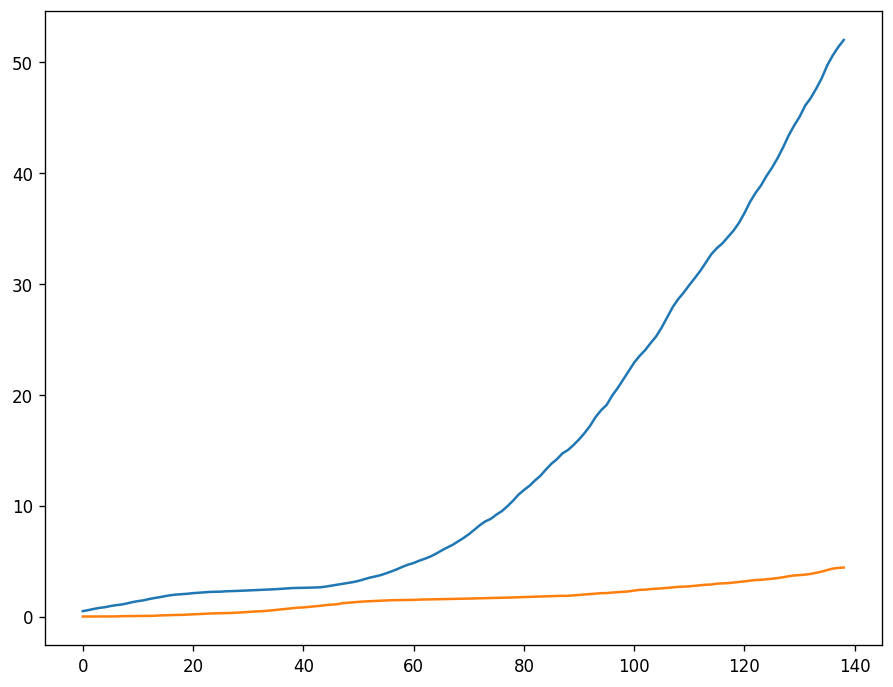

In [ ]:
plt.plot(range(len(vaccinated)),vaccinated)
plt.plot(range(len(vaccinated)),fully_vaccinated)

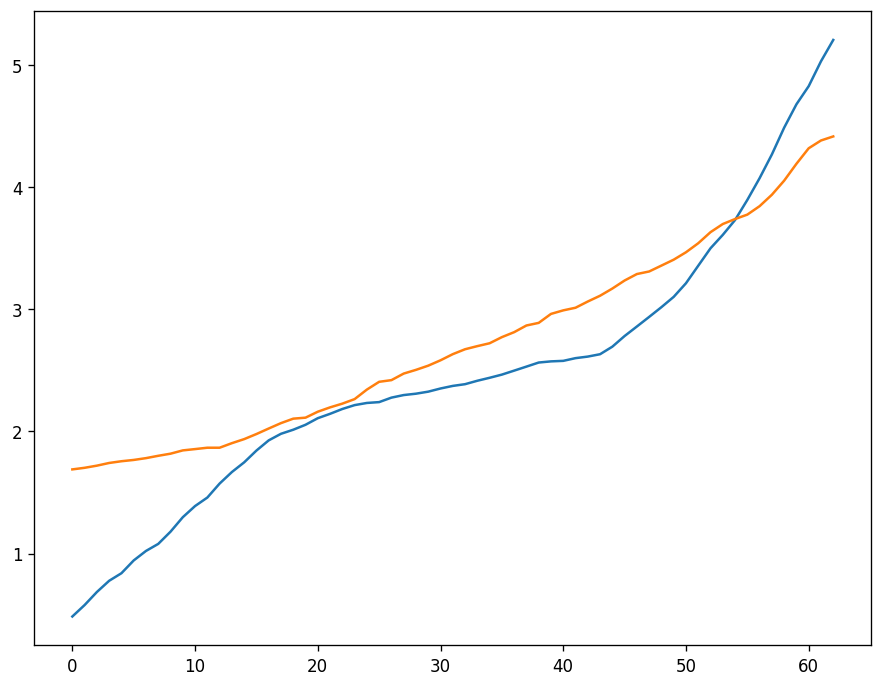

In [ ]:
plt.plot(range(len(vacNew)),vacNew)
plt.plot(range(len(fullVacNew)),fullVacNew)